In [30]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### 전이학습

In [10]:
# model_conv = ResNet50()

In [11]:
# include_top = False --> 특징 추출기 쪽만 가져오기
# model_conv = ResNet50(weights='imagenet',
#                       include_top = False, input_shape=(98,98,3))

model_conv = VGG16(weights='imagenet',
                      include_top = False, input_shape=(98,98,3))

In [12]:
model_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 98, 98, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 98, 98, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 98, 98, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 49, 49, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 49, 49, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 49, 49, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [13]:
from tensorflow.keras.preprocessing import image

In [14]:
#특징 추출기는 학습시 제외
for layer in model_conv.layers:
    layer.trainable = False
    

In [15]:
dataGen = image.ImageDataGenerator( rescale=1./255 )

In [16]:
trainGen = dataGen.flow_from_directory( 'wd/train', target_size=(98,98),batch_size=150)

Found 1242 images belonging to 2 classes.


In [17]:
x_train , y_train = trainGen.next()

In [18]:
model_conv

In [19]:
model = Sequential()
model.add(model_conv) # con, relu, pool
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 2, activation='softmax'))
# model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['acc'])
#미세조정..
model.compile(loss = 'categorical_crossentropy',
              optimizer= RMSprop(learning_rate=1e-4), metrics=['acc'])
model.fit(x_train,y_train,epochs=100)

Epoch 1/100
5/5 [==============================] - 2s 378ms/step - loss: 0.5978 - acc: 0.6600
Epoch 2/100
5/5 [==============================] - 2s 373ms/step - loss: 0.4264 - acc: 0.8933
Epoch 3/100
5/5 [==============================] - 2s 370ms/step - loss: 0.3651 - acc: 0.8933
Epoch 4/100
5/5 [==============================] - 2s 373ms/step - loss: 0.2885 - acc: 0.9467
Epoch 5/100
5/5 [==============================] - 2s 392ms/step - loss: 0.2433 - acc: 0.9733
Epoch 6/100
5/5 [==============================] - 2s 374ms/step - loss: 0.2119 - acc: 0.9733
Epoch 7/100
5/5 [==============================] - 2s 372ms/step - loss: 0.1913 - acc: 0.9667
Epoch 8/100
5/5 [==============================] - 2s 365ms/step - loss: 0.1564 - acc: 0.9733
Epoch 9/100
5/5 [==============================] - 2s 361ms/step - loss: 0.1328 - acc: 0.9800
Epoch 10/100
5/5 [==============================] - 2s 367ms/step - loss: 0.1249 - acc: 0.9867
Epoch 11/100
5/5 [==============================] - 2s 380m

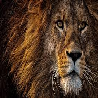

In [20]:
testImg = image.load_img( 'wd/test/lion/google_0010.jpg', target_size=(98,98))
testImg

In [21]:
imgArr = image.img_to_array(testImg)

In [22]:
list(model.predict(preprocess_input(np.expand_dims(imgArr, axis=0))).argmax(axis=1))[0]

0

In [23]:
trainGen = dataGen.flow_from_directory( 'wd/test', target_size=(98,98),batch_size=60)
x_test , y_test = trainGen.next()

Found 50 images belonging to 2 classes.


In [24]:
model.evaluate(x_train,y_train)

5/5 [==============================] - 2s 369ms/step - loss: 4.8478e-08 - acc: 1.0000


[4.8478437264520835e-08, 1.0]

In [25]:
model.evaluate(x_test,y_test)

2/2 [==============================] - 1s 228ms/step - loss: 0.3574 - acc: 0.9200


[0.35742127895355225, 0.9200000166893005]

<AxesSubplot:>

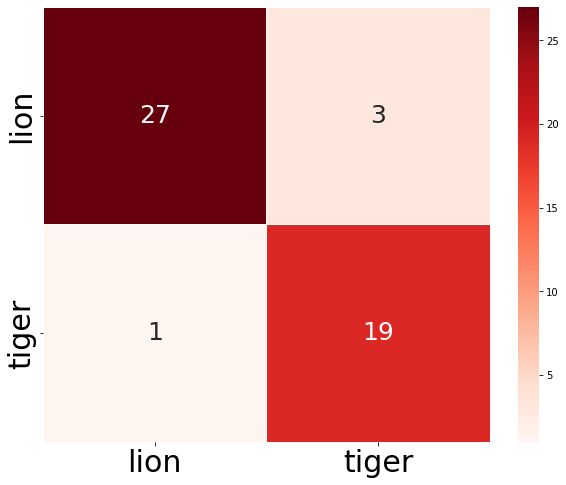

In [32]:
plt.rcParams['figure.figsize']=(10,8)
plt.tick_params(labelsize=30)
sns.heatmap(confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1)),
            annot=True,
            annot_kws={'size': 25},
            cmap='Reds',
            fmt = 'd', # 정수로 나오게
            linewidths=0.5,
            yticklabels=['lion','tiger'], # y축에 컬럼명 출력
            xticklabels=['lion','tiger'])